In [1]:
import pandas as pd
import numpy as np
import os
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# all the network and other def
from utils import model_dataset, CoAttention, HMCAN

# visualization of CoAttention
import seaborn as sn
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score, roc_auc_score

In [2]:
# specify GPU Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
df_train = pd.read_csv("../multimodal_only_samples/multimodal_train.tsv", sep='\t')
df_valid = pd.read_csv("../multimodal_only_samples/multimodal_validate.tsv", sep='\t')
df_test = pd.read_csv("../multimodal_only_samples/multimodal_test_public.tsv", sep='\t')

In [4]:
df_train.columns

Index(['author', 'clean_title', 'created_utc', 'domain', 'hasImage', 'id',
       'image_url', 'linked_submission_id', 'num_comments', 'score',
       'subreddit', 'title', 'upvote_ratio', '2_way_label', '3_way_label',
       '6_way_label'],
      dtype='object')

## Comment

In [5]:
# read comments data from csv
df_comments = pd.read_csv("../multimodal_only_samples/all_comments.tsv", sep='\t', encoding='utf-8', engine='python')
df_comments = df_comments.drop(df_comments.columns[[0]], axis=1)
df_comments = df_comments.dropna(subset=["id", "body"])

# create balanced data from it
dfs = []
comment_count = [0] * 6

### length of #sample for each label
sample_num = 500

for label in range(6):
    df = df_train.loc[df_train["6_way_label"] == label].dropna(subset=['num_comments', 'domain', 'subreddit'])
    df = df.loc[df["num_comments"] > 2.0]

    df = df.iloc[:sample_num]

    comment_count[label] = len(df)

    dfs.append(df)

balanced_df_train = pd.concat(dfs)

balanced_df_train = balanced_df_train.sample(frac=1)

print("Comment count:")
print(comment_count)

Comment count:
[500, 500, 500, 500, 0, 500]


### dataset
- word_embedding
- sentence_embedding

--> Read ModelDataset in model_dataset.py for details

In [7]:
data_num = 1250
assert(2 * data_num <= len(balanced_df_train))

word_train_dataset = model_dataset.ModelDataset(balanced_df_train.iloc[:data_num], df_comments, k=2, token_max_length=20)
word_valid_dataset = model_dataset.ModelDataset(balanced_df_train.iloc[data_num:2*data_num], df_comments, k=2, token_max_length=20)



  0%|          | 0/1250 [00:00<?, ?it/s]

100%|██████████| 1250/1250 [09:12<00:00,  2.26it/s]


In [8]:
sbert_train_dataset = None #model_dataset.ModelDataset(balanced_df_train.iloc[:data_num], df_comments, k=2)
sbert_valid_dataset = None #model_dataset.ModelDataset(balanced_df_train.iloc[data_num:2*data_num], df_comments, k=2)

In [9]:
print("word dataset shape")
print("embedding shape:", word_train_dataset[0]["embedding"].shape) # S: [num_layers, max_token, 384]
print("comment shape:", word_train_dataset[0]["comment"].shape) # C
print(f"len of dataset: train: {len(word_train_dataset)}, val: {len(word_valid_dataset)}")

# print("sbert dataset shape")
# print("embedding shape:", sbert_train_dataset[0]["embedding"].shape) # S: [num_layers, 384]
# print("comment shape:", sbert_train_dataset[0]["comment"].shape) # C
# print(f"len of dataset: train: {len(sbert_train_dataset)}, val: {len(sbert_valid_dataset)}")

word dataset shape
embedding shape: torch.Size([1, 20, 1024])
comment shape: torch.Size([2, 20, 1024])
len of dataset: train: 1250, val: 1250


### Evaluation
[guide](https://www.kaggle.com/code/nkitgupta/evaluation-metrics-for-multi-class-classification) for multiclass metrics

In [10]:
# ROC-AUC curve
def roc_auc_score_multiclass(actual_class, pred_class, average = "macro"):
    
    # creating a set of all the unique classes using the actual class list
    unique_class = set(actual_class)
    roc_auc_dict = {}
    for per_class in unique_class:
        
        # creating a list of all the classes except the current class 
        other_class = [x for x in unique_class if x != per_class]

        # marking the current class as 1 and all other classes as 0
        new_actual_class = [0 if x in other_class else 1 for x in actual_class]
        new_pred_class = [0 if x in other_class else 1 for x in pred_class]

        # using the sklearn metrics method to calculate the roc_auc_score
        roc_auc = roc_auc_score(new_actual_class, new_pred_class, average = average)
        roc_auc_dict[per_class] = roc_auc

    return roc_auc_dict


def total_evaluate(network, best_weight_path:str, valid_dataset:Dataset):
    """
    Evaluate @network for the best weight obtained in the @best_weight_path path
    using @valid_loader to predict
    Output different mertics for multi-class classification
    """
    network.load_state_dict(torch.load(best_weight_path))
    network.to(device)
    network.eval()

    all_preds = []
    all_labels = []
    all_outputs = []

    count_labels = [0] * 6

    valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
    with torch.no_grad():
        for _, batch in enumerate(tqdm(valid_loader)):
            embeddings = batch['embedding']
            comments = batch['comment']
            labels = batch['label']

            _, label = torch.max(labels, 1)
            for l in label:
                count_labels[int(l)] += 1

            # Forward pass
            embeddings = embeddings.to(device)
            comments = comments.to(device)
            outputs = network(embeddings, comments)

            # Predictions
            _, preds = torch.max(outputs, 1)
            preds = preds.cpu()

            _, labels = torch.max(labels, 1)
            labels = labels.cpu()

            outputs = outputs.cpu()
            all_preds.extend(preds.numpy())
            all_labels.extend(labels.numpy())
            all_outputs.extend(outputs.numpy())

    # evaluation metrics:
    # 1. accuracy
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"accuracy: {accuracy}")

    # 2. Macro, Micro score (P)
    # Macro: calculate precision for each class and average them
    macro_score = precision_score(all_labels, all_preds, average="macro")
    # Micro: calculate class wise TP and FP and use that to calculate overall score: tp / (tp + fp)
    micro_score = precision_score(all_labels, all_preds, average="micro")
    print(f"Macro precision: {macro_score}")
    print(f"Micro precision: {micro_score}")

    # 3. Recall: TP / (TP+FN) (R)
    macro_recall = recall_score(all_labels, all_preds, average='macro')
    micro_recall = recall_score(all_labels, all_preds, average='micro')
    print(f"Macro recall: {macro_recall}")
    print(f"Micro recall: {micro_recall}")

    # 4. F1 score: 2PR / (P+R)
    macro_f1_score = f1_score(all_labels, all_preds, average='macro')
    micro_f1_score = f1_score(all_labels, all_preds, average='micro')
    print(f"Macro F1: {macro_f1_score}")
    print(f"Micro F1: {micro_f1_score}")

    # 5. Area under ROC curve
    # ROC curve describes how well the model can distinguish between classes
    roc_auc_dict = roc_auc_score_multiclass(all_labels, all_preds, average='macro')
    print("Roc-auc score for each class:")
    print(roc_auc_dict)

    # 6. confusion matrix
    confusion_mat = confusion_matrix(all_labels, all_preds)
    print('Confusion Matrix: ')

    # visualize
    df_cm = pd.DataFrame(
        confusion_mat, 
        index=[i for i in "01235"],
        columns=[i for i in "01235"],
    )

    plt.figure(figsize=(5, 5))
    sn.heatmap(df_cm, annot=True)

### networks
- SBert_model: simply a FC layer with concat input (for SBERT embeddings)
- HMCAN: hirarchical Multi-Modal Contextual Attention Network

In [16]:
def experiment(network, train_dataset, valid_dataset, exp_name="test"):
    network.to(device)

    batch_size = 16
    learning_rate = 1e-3
    epochs = 5

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

    print("num of input samples:", len(train_dataset))

    # define loss and optimizer
    # cce loss in TF is not equivalent with pytorch's CE loss!
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.RMSprop(network.parameters(), lr=learning_rate)

    # record best
    best_acc = 0.0
    weight_path = "../models/weights/"
    best_weight_path = ""

    # training loop
    for epoch in range(epochs):
        network.eval()
        for _, batch in enumerate(tqdm(train_loader)):
            embeddings = batch["embedding"]
            comments = batch["comment"]
            labels = batch["label"]

            # forward pass
            embeddings = embeddings.to(device)
            comments = comments.to(device)
            outputs = network(embeddings, comments)
            
            # compute loss
            labels = labels.to(device)
            loss = criterion(outputs, labels)

            # backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # validation after each epoch
        network.eval()
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for _, batch in enumerate(tqdm(valid_loader)):
                embeddings = batch['embedding']
                comments = batch['comment']
                labels = batch['label']

                # Forward pass
                embeddings = embeddings.to(device)
                comments = comments.to(device)
                outputs = network(embeddings, comments)

                # Predictions
                _, preds = torch.max(outputs, 1)
                preds = preds.cpu()

                _, labels = torch.max(labels, 1)
                labels = labels.cpu()

                all_preds.extend(preds.numpy())
                all_labels.extend(labels.numpy())

        # Calculate accuracy
        accuracy = accuracy_score(all_labels, all_preds)
        print(f'Epoch {epoch + 1}/{epochs}, Accuracy: {accuracy:.4f}')

        # save weight
        if(accuracy > best_acc):
            best_weight_path = os.path.join(weight_path, f"{exp_name}_{int(accuracy*100)}.pth")
            torch.save(network.state_dict(), best_weight_path)
            best_acc = accuracy
    print("---------\n")

    return best_weight_path

In [17]:
## adjust experiement input here ##
networks = [
    # co-attention network
    CoAttention.CoAttentionNetwork(feature_size=1024, word_attn=True),
    CoAttention.CoAttentionNetwork(feature_size=1024, setting="defend_co")
    # fc network
    # HMCAN.FC_model(),
    # HMCAN.FC_model(feature_size=1024),
    # # HMCAN
    # HMCAN.HMCAN(),
    # HMCAN.HMCAN(feature_size=1024),
]

loaders = ["word"] * (len(networks))
names = ["Co_word", "Co_no_co", ]

In [ ]:
# output weight path
save_dirs = []

for network, loader, name in zip(networks, loaders, names):
    print(name)
    # pick dataset
    train_dataset = sbert_train_dataset
    valid_dataset = sbert_valid_dataset
    if (loader == "word"):
        train_dataset = word_train_dataset
        valid_dataset = word_valid_dataset

    # apply
    save_dirs.append(experiment(network, train_dataset, valid_dataset, name))

In [19]:
save_dirs

['../models/weights/Co_word_59.pth', '../models/weights/Co_no_co_54.pth']

  0%|          | 0/40 [00:00<?, ?it/s]

100%|██████████| 40/40 [05:25<00:00,  8.15s/it]


accuracy: 0.5952
Macro precision: 0.619942227366937
Micro precision: 0.5952
Macro recall: 0.5961346979372847
Micro recall: 0.5952
Macro F1: 0.5885406047369548
Micro F1: 0.5952
Roc-auc score for each class:
{0: 0.711538148160219, 1: 0.8146851458373575, 2: 0.6513922183293381, 3: 0.8382876969242311, 5: 0.7218391669173937}
Confusion Matrix: 
----------



100%|██████████| 40/40 [05:48<00:00,  8.72s/it]


accuracy: 0.5408
Macro precision: 0.5419764054318859
Micro precision: 0.5408
Macro recall: 0.5412674844239616
Micro recall: 0.5408
Macro F1: 0.5326049717480176
Micro F1: 0.5408
Roc-auc score for each class:
{0: 0.6031841736466448, 1: 0.7645555662867813, 2: 0.6712228778658799, 3: 0.7879704301075269, 5: 0.7397243673319293}
Confusion Matrix: 
----------



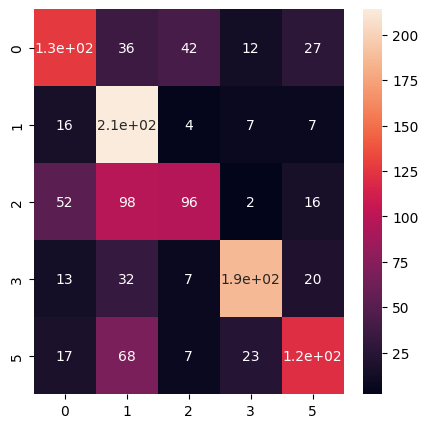

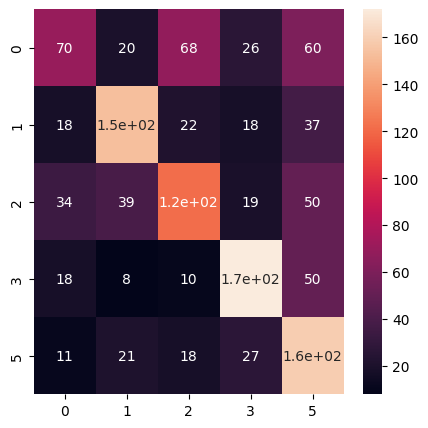

In [20]:
# evaluate the best model of each network
for network, w_path, loader in zip(networks, save_dirs, loaders):
    # pick dataset
    valid_dataset = sbert_valid_dataset
    if (loader == "word"):
        valid_dataset = word_valid_dataset
    
    total_evaluate(network, w_path, valid_dataset)
    print("----------\n")